## PHYS-F-302 : Mécanique Quantique, partie numérique

Florian Danneau

Nous allons décrire le flux de Stokes dans une cavité carrée en résolvant une équation biharmonique. Le flux de Stokes nous permet de simplifier les équations de Navier-Stokes, en éliminant la non-linéarité. 

Il faut tout d'abord discrétiser une équation biharmonique :

\begin{equation}
\nabla^{4}\psi = 0
\end{equation}


On a donc :

\begin{equation}
\nabla^{2}(\nabla^{2}\psi) = 0
\end{equation}

\begin{equation}
\partial_{x}^{4}\psi + \partial_{y}^{4}\psi + 2\partial_{x}\partial_{y}\psi = 0 
\end{equation}

Maintenant, nous allons la discrétiser :
    
\begin{equation}
\partial_{x}^{4}\psi = \dfrac{\psi[i-2,j]-4\psi[i-1,j] + 6\psi[i,j]-4\psi[i+1,j]+ \psi[i+2,j]}{dx^{4}}
\end{equation}

\begin{equation}
\partial_{y}^{4}\psi = \dfrac{\psi[i,j-2]-4\psi[i,j-1] + 6\psi[i,j]-4\psi[i,j+1]+ \psi[i,j+2]}{dy^{4}}
\end{equation}

\begin{equation}
\partial_{x}^{2}\partial_{y}^{2}\psi = \dfrac{\psi[i-1,j+1]-2\psi[i,j+1] + \psi[i+1,j+1]-2\psi[i-1,j]+ 4\psi[i,j]-2\psi[i+1,j]+\psi[i-1,j-1]-2\psi[i,j-1]+\psi[i+1,j-1]}{dx^{2}dy^{2}} 
\end{equation}

\begin{equation}
\nabla^{4}\psi = \dfrac{\psi[i-2,j]-4\psi[i-1,j] + 6\psi[i,j]-4\psi[i+1,j]+ \psi[i+2,j]}{dx^{4}} + \dfrac{\psi[i,j-2]-4\psi[i,j-1] + 6\psi[i,j]-4\psi[i,j+1]+ \psi[i,j+2]}{dy^{4}}+ 2\dfrac{\psi[i-1,j+1]-2\psi[i,j+1] + \psi[i+1,j+1]-2\psi[i-1,j]+ 4\psi[i,j]-2\psi[i+1,j]+\psi[i-1,j-1]-2\psi[i,j-1]+\psi[i+1,j-1]}{dx^{2}dy^{2}} = 0
\end{equation}

 Nous avons utilisé le lien suivant pour trouver les coefficients :
https://en.wikipedia.org/wiki/Finite_difference_coefficient

Nous importons ce dont nous avons besoin pour résoudre notre problème.

In [231]:
import matplotlib.pyplot as plt
import numpy
import scipy.sparse as sp
import scipy.sparse.linalg
from math import pi, cos, sin
%matplotlib inline
from matplotlib import rcParams 
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

On va également utiliser les paramètres de discrétisation donnés dans le MOOC.

In [232]:
nx = 41
ny = 41

l = 1.
h = 1.

dx = l/(nx-1)
dy = h/(ny-1)

l1_target = 1e-8

x  = numpy.linspace(0,l,nx)
y  = numpy.linspace(0,h,ny)
X,Y = numpy.meshgrid(x,y)

b = numpy.zeros((nx,ny))

p_i = numpy.zeros((nx,ny))


In [233]:
def L1norm(new, old):
    norm = numpy.sum(numpy.abs(new-old))
    return norm

Pour implémenter nos conditions aux bords, nous allons d'abord les discrétiser à l'aide du lien wikipédia.

On a donc  :

\begin{equation}
\partial_{x} \psi = \dfrac{\dfrac{-3}{2}\psi[i,j] + 2\psi[i,j+1] \dfrac{-1}{2} \psi[i,j+2]}{dx}
\end{equation}

\begin{equation}
\partial_{y} \psi = \dfrac{\dfrac{-3}{2}\psi[i,j] + 2\psi[i+1,j] \dfrac{-1}{2} \psi[i+2,j]}{dy}
\end{equation}
qui sont les conditions de discrétisation forward du problème.

Dès lors, on peut implémenter nos conditions aux bords comme suit :

On commence par les conditions sur les dérivées de $\psi$ , càd $\partial_{x} \psi$ et $\partial_{y} \psi$

In [234]:
cond1 = ((-3/2)*p_i[:,0] + 2*p_i[:,1] -(1/2)*p_i[:,2])/dx == 0 #forward pour le côté vertical droit
cond2 = ((-3/2)*p_i[:,-1] + 2*p_i[:,0] -(1/2)*p_i[:,1])/dx == 0 #forward pour le côté vertical gauche
cond3 = ((-3/2)*p_i[0,:] + 2*p_i[1,:] -(1/2)*p_i[2,:])/dy == 0 #forward pour le côté horizontal bas
cond4 = ((-3/2)*p_i[-1,:] + 2*p_i[0,:] -(1/2)*p_i[1,:])/dy == 1 #forward pour le côté horizontal haut

Ensuite on implémente celles sur $\psi$

In [235]:
p_i[:,0] = 0 # (1)
p_i[:,-1] = 0 # (2)
p_i[0,:] = 0 # (3)
p_i[-1,:] = 0 # (4)

Or avec les conditions (1) et (2), on tire de cond2 que $p_i [:,1] = 0$  et donc de cond1 que $p_i [:,2] = 0$ également. 
Avec (3) et (4), on tire de cond4 que $p_i [1,:] = -2dy$ et finalement de cond3 on a que $ p_i [2,:] = -8dy$.


Donc : 

In [236]:
p_i[1,:] = -2*dy
p_i[2,:] = -8*dy
# On remet les conditions aux bords sur psi pour "coller" au problème 
p_i[0,:] = 0
p_i[-1,:] = 0
p_i[:,0] = 0
p_i[:,-1] = 0
 
print(p_i)

[[ 0.    0.    0.   ...  0.    0.    0.  ]
 [ 0.   -0.05 -0.05 ... -0.05 -0.05  0.  ]
 [ 0.   -0.2  -0.2  ... -0.2  -0.2   0.  ]
 ...
 [ 0.    0.    0.   ...  0.    0.    0.  ]
 [ 0.    0.    0.   ...  0.    0.    0.  ]
 [ 0.    0.    0.   ...  0.    0.    0.  ]]


On doit utiliser la méthode des gradients conjugués qui est donnée explicitement dans le mooc, pour résoudre l'équation. Cependant, comme nous travaillons avec une équation biharmonique, il faut modifier cette méthode des gradients conjugués pour qu'elle "réponde" à une discrétisation de degré 4.

In [237]:
def conjugate_gradient_2d(p, b, dx, dy, l2_target):
    '''Performs cg relaxation
    Assumes Dirichlet boundary conditions p=0
    
    Parameters:
    ----------
    p : 2D array of floats
        Initial guess
    b : 2D array of floats
        Source term
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    l2_target: float
        exit criterion
        
    Returns:
    -------
    p: 2D array of float
        Distribution after relaxation
    '''
    ny, nx = p.shape
    r  = numpy.zeros((ny,nx)) # residual
    Ad  = numpy.zeros((ny,nx)) # to store result of matrix multiplication 
    
    l2_norm = 1
    iterations = 0
    l2_conv = []
    
    # Step-0 We compute the initial residual and 
    # the first search direction is just this residual
    r[2:-2,2:-2] = b[2:-2,2:-2] - (1*p[2:-2,:-4]+ 2*p[1:-3,1:-3]-8*p[2:-2,1:-3]+2*p[3:-1,1:-3]+1*p[:-4,2:-2]-8*p[1:-3,2:-2] +20*p[2:-2,2:-2]-8*p[3:-1,2:-2] +1*p[4:,2:-2]+2*p[1:-3,3:-1]-8*p[2:-2,3:-1]+2*p[3:-1,3:-1]+1*p[2:-2,4:])/dx**4
    d = r.copy()
    rho = numpy.sum(r*r)
    Ad[2:-2,2:-2] = (+1)*(1*d[2:-2,:-4]+ 2*d[1:-3,1:-3]-8*d[2:-2,1:-3]+2*d[3:-1,1:-3]+1*d[:-4,2:-2]-8*d[1:-3,2:-2] +20*d[2:-2,2:-2]-8*d[3:-1,2:-2] +1*d[4:,2:-2]+2*d[1:-3,3:-1]-8*d[2:-2,3:-1]+2*d[3:-1,3:-1]+1*d[2:-2,4:])/dx**4
    sigma = numpy.sum(d*Ad)
    
    # Iterations
    while l2_norm > l2_target:

        pk = p.copy()
        rk = r.copy()
        dk = d.copy()
        
        alpha = rho/sigma

        p = pk + alpha*dk
        r = rk- alpha*Ad
        
        rhop1 = numpy.sum(r*r)
        beta = rhop1 / rho
        rho = rhop1
        
        d = r + beta*dk
        Ad[2:-2,2:-2] = (+1)*(1*d[2:-2,:-4]+ 2*d[1:-3,1:-3]-8*d[2:-2,1:-3]+2*d[3:-1,1:-3]+1*d[:-4,2:-2]-8*d[1:-3,2:-2] +20*d[2:-2,2:-2]-8*d[3:-1,2:-2] +1*d[4:,2:-2]+2*d[1:-3,3:-1]-8*d[2:-2,3:-1]+2*d[3:-1,3:-1]+1*d[2:-2,4:])/dx**4
        sigma = numpy.sum(d*Ad)
        
        # BCs are automatically enforced
        
        l2_norm = L2_rel_error(pk,p)
        iterations += 1
        l2_conv.append(l2_norm)
    
    print('Number of CG iterations: {0:d}'.format(iterations))
    return p, l2_conv     

In [238]:
p, l1_conv = conjugate_gradient_2d(p_i.copy(), b, dx, dy, l1_target)

Number of CG iterations: 609


In [239]:
print(p)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -5.00000000e-02 -5.00000000e-02 ... -5.00000000e-02
  -5.00000000e-02  0.00000000e+00]
 [ 0.00000000e+00 -2.00000000e-01 -1.36526598e-01 ... -1.36526598e-01
  -2.00000000e-01  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  3.65117485e-06 ...  3.65121391e-06
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


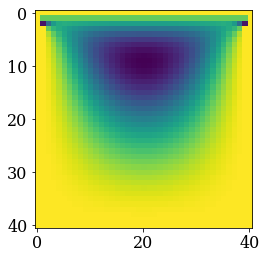

In [240]:
plt.imshow(p)

Il ne nous reste plus qu'à calculer la valeur de la fonction de flux $\psi$ après qu'elle ait atteint son état stationnaire. Pour ce faire, on connait la valeur de $dx$ et $dy$. Donc il suffit de diviser les coordonées des points par $dx$ ou $dy$ pour trouver sa place dans notre matrice $p$

Avec Python, nous savons que pour un élément de matrice, le premier indice donne la ligne et le deuxième donne la colonne. Or quand on prend un point (x,y), on donne d'abord la colonne puis la ligne. Donc pour trouver la valeur de la fonction aux 4 points demandés, il faut "inverser" le "x" et le "y" dans les coordonnées du point. 

Comme Python est plus précis qu'une calculette, on utilise le petit "tip" qui est de rajouter $0.5$ quand on calcule l'endroit des coordonnées dans la matrice $p$.

Quelle est la valeur de la fonction de flux $\psi$ en (0.6;0.2)?

In [241]:
t = int(0.5 + 0.2/dy)
q = int(0.5 + 0.6/dx)

p[t,q]

-0.2004765158871918

Quelle est la valeur de la fonction de flux $\psi$ en (0.6;0.4)?

In [242]:
t = int(0.5 + 0.4/dy)
q = int(0.5 + 0.6/dx)

p[t,q]

-0.15175443390279872

Quelle est la valeur de la fonction de flux $\psi$ en (0.6;0.6)?

In [243]:
t = int(0.5 + 0.6/dy)
q = int(0.5 + 0.6/dx)

p[t,q]

-0.07167156557869732

Quelle est la valeur de la fonction de flux $\psi$ en (0.6;0.8)?

In [244]:
t = int(0.5 + 0.8/dy)
q = int(0.5 + 0.6/dx)

p[t,q]

-0.018517742397612755

Finalement, nous venons de décrire l'évolution du flux de Stokes dans une cavité carrée avec certaines conditions initiales. On apprend que la situation évolue depuis les conditions initiales jusqu'à un état d'équilibre. Cet état d'équilibre est atteint en $609$ itérations. On a vu dans le MOOC que la méthode des gradients conjugués était la plus rapide. On peut donc dire que c'est la méthode la plus adéquate pour résoudre ce problème par rapport à celle de "Jacobi" et celle de "steepest descent" qui auraient demandé beaucoup plus d'itérations et donc un résultat qui aurait été obtenu en plus de temps (en comparant avec l'exemple du MOOC présent dans la leçon 5.4).